# Numerical demonstration of transient noise condensation in systems with nonlinear loss

The purpose of this notebook is to demonstrate that the nonlinear coupled cavity Hamiltonian supports transient noise condensation similar to what is predicted by solving the analytical models predicted in the text. We will demonstrate this by the master equation for the nonlinear Fano resonance (Eq. (8) of Supplementary Information). Compared to the analytical theory, we do not assume the adiabatic approximation in the numerical solutions. Because we are numerically time-evolving an open system according to a Liouvillian, $-$ which has $N^4$ elements in its matrix representation ($N$ being the Hilbert space dimension) $-$ it is time-consuming to do simulations for large Fock states. Thus we demonstrate a "toy" example in which a 30-photon optical Fock state results (already such simulations take nearly two hours).

We note that the descriptions and discussion provided in this notebook are largely similar to the discussion in the relevant section of the Supplementary Information.

In [59]:
## Load packages and set some fonts for the plots.

using LinearAlgebra
using DifferentialEquations
using QuantumOptics
using Distributions
using SparseArrays
using Arpack
using PyPlot
using ForwardDiff
using DelimitedFiles

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 12;
rcParams["font.sans-serif"] = "Arial";

In [60]:
## Auxiliary functions 

function stats(nvals,dist)
    
    n2vals = nvals.^2;
    nexp = sum(nvals.*dist);
    n2exp = sum(n2vals.*dist);
    dn = sqrt(n2exp-nexp^2);
    fano = dn^2/nexp;
    
    return nexp, dn, fano;
end

function loss(wa,wd,κ,γ,λ)
    δ = wa - wd;
    Lw = (κ*δ^2 + γ*abs(λ)^2 + 2*sqrt(κ*γ)*δ*real(λ)) / (δ^2 + γ^2 / 4);
    return Lw
end

function ωn(wa, β, n)
    wn = wa*(1+2*β*n);
    return wn
end

ωn (generic function with 1 method)

Let's consider a system that evolves according to the master equation, Eq. (8) of the SI. We need to specify the frequencies of the $a$ and $d$ resonances, as well as the nonlinearity $\beta$, the coupling $\lambda$, and the decay rates $\kappa$ and $\lambda$. These parameters specify the temporal loss coefficient $\kappa(n) = L(n)/n$ shown in Eq. (24) of the SI. This loss constant is plotted in the cell below. It clearly has a zero for some $n_0$ (in this case about 30). According to the analytical theory, an initial photon distribution in $a$ should tend to a Fock state of order $n_0 \approx 30$. 

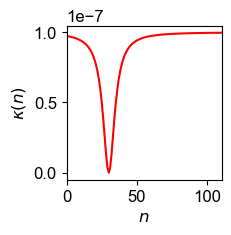

In [61]:
ωc = 1.0;
δ = -30e-3
ωd = 1 + δ;

β = -5e-4;
κ = 1e-7;
γ = 1e-2;
λ = 0;

nvals = [0:1:110;]
Ln = real([loss(ωn(ωc, β, nn),ωd,κ,γ,λ) for nn in nvals])

figure(figsize=(2,2));
plot(nvals,Ln,linestyle="-",color="red")
xlabel(L"n")
ylabel(L"κ(n)")
xlim(0,maximum(nvals));
savefig("loss_numerical_condensation.svg",format="svg")

The cell below performs a time-evolution of the master equation (Eq. (8) of the SI, without an adiabatic approximation). This is done in Julia's quantum optics package (QuantumOptics.jl, see https://qojulia.org/). The cell below follows a standard procedure for quantum calculations in QuantumOptics: set up a Hilbert space, system and jump operators, and a Liouvillian. Then, time-evolve the Liouvillian.

In [62]:
## Setting up Hilbert space and operators

N_cutoff = 110;
N_d = 1;

nvals_a = [0:1:N_cutoff;];
nvals_d = [0:1:N_d;];

b_fock = FockBasis(N_cutoff);
b_d = FockBasis(N_d);

b = b_fock ⊗ b_d;

a = destroy(b_fock);
ad = create(b_fock);
n = number(b_fock);
Ip = identityoperator(b_fock);

d = destroy(b_d);
dd = create(b_d);
nd = number(b_d);
Id = identityoperator(b_d);

## Some useful auxiliary operators.

A = sqrt(Complex(γ/(κ+γ)))*(a ⊗ Id) - sqrt(κ/(κ+γ))*(Ip ⊗ d)
Ad = dagger(A);
nA = Ad*A

X = (sqrt(Complex(κ/(κ+γ)))*(a ⊗ Id) + sqrt(Complex(γ/(κ+γ)))*(Ip ⊗ d))
Xd = dagger(X);

## Model parameters

ωc = 1.0;
δ = -30e-3
ωd = 1 + δ;

β = -5e-4;
κ = 1e-7;
γ = 1e-2;
λ = 0;

## Setting up Hamiltonian + Lindblad terms (no gain) 

H_nl =  ωc*n + ωc*β*ad*ad*a*a;
H_rwa =  H_nl ⊗ Id +  ωd*(Ip ⊗ nd) + (λ*a ⊗ dd + conj(λ)*ad ⊗ d);

jump_γ = sqrt(κ+γ)*X;
jumps = [jump_γ];
rates = [1];

## Setting up initial conditions, corresponding to a de-phased coherent state.

na0 = 70;
nd0 = 0;

ψ0 = coherentstate(b_fock,sqrt(na0)) ⊗ fockstate(b_d,nd0);

# This is "removing the coherences" from a coherent state to make a de-phased one.
ρ0 = ψ0 ⊗ dagger(ψ0);
for ii = 1:size(ρ0.data,1)
    for jj = 1:size(ρ0.data,1)
        if ii != jj
            ρ0.data[ii,jj] = 0
        end
    end
end

# Max time and time-step for master equation propagation.  
tmax = 5/abs(κ)
tsteps = 1000;
dt = tmax/tsteps;
tspan = [0:dt:tmax;];

# Creates the Liouvillian operator. This is not used below, but is occasionally useful.
liouville_op = liouvillian(H_rwa, jumps);
liouville_mat = sparse(liouville_op).data;

In [32]:
@elapsed tout, ρt = timeevolution.master(tspan, ρ0, H_rwa, jumps; maxiters = 1e7)

6477.89420883

The cell below plots the photon probability distributions as a function of time. As can very clearly be seen, the distribution evolves towards a Fock state near the zero of the loss plotted above (about $n=30$). Notice the very strong resemblance between this plot and the plot shown in Fig. 2 of the main text, calculated analytically.

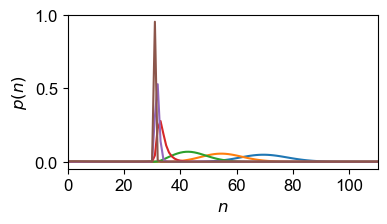

In [254]:
plot_times = [1, 50, 100, 200, 300, 1000];
figure(figsize=(4,2));
for ii = 1:length(plot_times)
    tt = plot_times[ii];
    plot(diag(ptrace(ρt[tt],2).data));
end
xlabel(L"n")
ylabel(L"p(n)")
xlim(0,N_cutoff);
savefig("transient_statistics_numerical_condensation.svg",format="svg")

Zooming in on the distribution plotted for the last time in the simulation, we see that the system tends very closely to a Fock state. This state has a 96% chance of being in a 30-photon state. A Poisson distribution of the same mean would have a 7% chance of having the same number of photons.

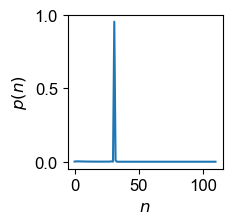

In [218]:
plot_times = [1000];
figure(figsize=(2,2));
for ii = 1:length(plot_times)
    tt = plot_times[ii];
    plot(diag(ptrace(ρt[tt],2).data));
end
xlabel(L"n")
ylabel(L"p(n)");

The cells below calculate various observables and plot the first two cumulants as well as the Fano factor.

In [198]:
na_exp = real(expect(n ⊗ Id, ρt));
na2_exp = real(expect(n^2 ⊗ Id, ρt));
dn2_exp = na2_exp - na_exp.^2;
fano_exp = dn2_exp ./ na_exp;

nd_exp = real(expect(Ip ⊗ nd, ρt));

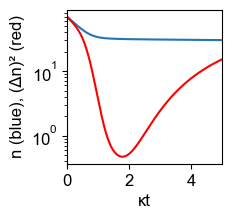

In [257]:
figure(figsize=(2,2));
semilogy(κ*tout,na_exp);
semilogy(κ*tout,dn2_exp,color="r");
xlim(0,5)
xlabel("κt")
ylabel("n (blue), (Δn)² (red)");
savefig("cumulants_numerical_condensation.svg",format="svg")

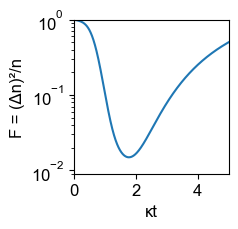

In [235]:
figure(figsize=(2,2));
semilogy(κ*tout,fano_exp);
xlim(0,5)
xlabel("κt")
ylabel("F = (Δn)²/n");
ylim(0.009,1);

The cell below plots the mean number of photons in $d$, showing that indeed, this mode cannot sustain buildup of excitations, as assumed in the derivations of the SI.

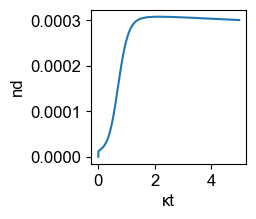

PyObject Text(25.0, 0.5, 'nd')

In [252]:
figure(figsize=(2,2));
plot(κ*tout,nd_exp);
xlabel("κt")
ylabel("nd")

You may have noticed an apparent discrepancy between the probability distributions and the Fano factor. The probability distribution at the final time is more sharply peaked around $n=30$ than at earlier times. But the Fano factor is higher (and in fact, appears to be quite high (about 0.5), indicating a somewhat modest noise reduction). 

This happens because it appears that a small part of the probability distribution, for lack of a better word, "tunnels" through the zero of the loss. You can see that the probability of being in the vacuum state increases over time (to a small value). In other words, the system displays some signature of bistability: the vast majority of the state is in the 30-photon Fock state while a very small part is in the vacuum state. 

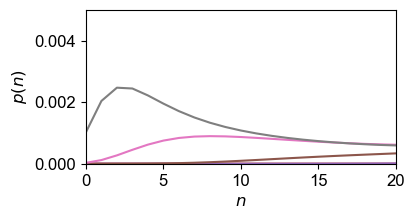

In [256]:
plot_times = [1, 50, 100, 200, 300, 500, 750, 1000];
figure(figsize=(4,2));
for ii = 1:length(plot_times)
    tt = plot_times[ii];
    plot(diag(ptrace(ρt[tt],2).data));
end
xlabel(L"n")
ylabel(L"p(n)")
xlim(0,20)
ylim(0,0.005)
savefig("transient_statistics_tunneling_numerical_condensation.svg",format="svg")

This bistability is somewhat unsurprising since the loss has zeros in two places (0 and $n_0$), indicating two valid steady states. We speculate that small (e.g., second-order) corrections away from adiabatic elimination could cause this (but we do not yet conclusively know what terms cause this).

Nevertheless, the state already demonstrated through these simulations, would represent both the highest optical Fock state realized (by over an order of magnitude), and with a very high fidelity (about 96%). It is likely that changes in parameters can improve this (since we made no attempt to optimize this).

## Using preloaded data 

As the numerical evolution of the Lindblad operator is fairly slow, you may also instead run the cells below. They load a pre-calculated time-dependent density matrix calculated in the cells above and convert it into Operator types suitable for analysis in QuantumOptics.jl. The density matrix is roughly 1GB so this cell will take a few minutes to run.

In [30]:
## This is copied from above so that you can just (after loading needed packages) run these cells.

ωc = 1.0;
δ = -30e-3
ωd = 1 + δ;

β = -5e-4;
κ = 1e-7;
γ = 1e-2;
λ = 0;

N_cutoff = 110;
N_d = 1;

nvals_a = [0:1:N_cutoff;];
nvals_d = [0:1:N_d;];

b_fock = FockBasis(N_cutoff);
b_d = FockBasis(N_d);

b = b_fock ⊗ b_d;

a = destroy(b_fock);
ad = create(b_fock);
n = number(b_fock);
Ip = identityoperator(b_fock);

d = destroy(b_d);
dd = create(b_d);
nd = number(b_d);
Id = identityoperator(b_d);

In [31]:
rhot_re = readdlm("ρt_data_re.csv");
rhot_im = readdlm("ρt_data_im.csv");
tvals = readdlm("tvals.csv");

In [32]:
hilbert_dim = Int64(sqrt(length(rhot_re)/length(tvals)));
n_times = length(tvals);
ρt_array = Array{Any}(undef,n_times);

for ii=1:n_times
    ind_min = (ii-1)*hilbert_dim^2 + 1; 
    ind_max = ii*hilbert_dim^2;
    ρt_array[ii] = DenseOperator(b,ComplexF64.(reshape(rhot_re[ind_min:ind_max],(hilbert_dim,hilbert_dim)))) +
                1.0im*DenseOperator(b,ComplexF64.(reshape(rhot_im[ind_min:ind_max],(hilbert_dim,hilbert_dim))));
end

In [33]:
na_exp = real(expect(n ⊗ Id, ρt_array));
na2_exp = real(expect(n^2 ⊗ Id, ρt_array));
dn2_exp = na2_exp - na_exp.^2;
fano_exp = dn2_exp ./ na_exp;
nd_exp = real(expect(Ip ⊗ nd, ρt_array));
nd2_exp = real(expect((Ip ⊗ nd)^2, ρt_array));

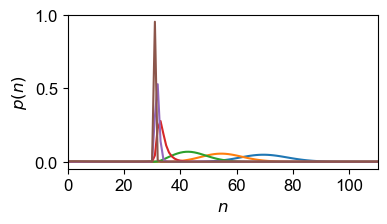

In [34]:
plot_times = [1, 50, 100, 200, 300, 1000];
figure(figsize=(4,2));
for ii = 1:length(plot_times)
    tt = plot_times[ii];
    plot(diag(ptrace(ρt_array[tt],2).data));
end
xlabel(L"n")
ylabel(L"p(n)")
xlim(0,N_cutoff);

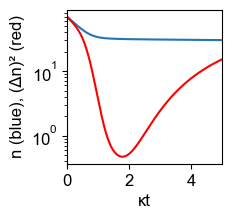

In [47]:
figure(figsize=(2,2));
semilogy(κ*tvals,na_exp);
semilogy(κ*tvals,dn2_exp,color="r");
xlim(0,5)
xlabel("κt")
ylabel("n (blue), (Δn)² (red)");